In [2]:

import os
import pandas as pd

# CSVの読み込み
df = pd.read_csv("C:/Users/yuba1/Downloads/archive/Data_Entry_2017.csv")

# ラベル付け: 'Mass' を含むかどうかで癌判定
df["Cancer"] = df["Finding Labels"].apply(lambda x: 1 if "Mass" in x else 0)


In [3]:

from sklearn.utils import shuffle

# 陽性データと陰性データをバランスさせる
df_1 = df[df["Cancer"] == 1]
df_0 = df[df["Cancer"] == 0].sample(n=len(df_1), random_state=42)
df_balanced = pd.concat([df_1, df_0])
df_balanced = shuffle(df_balanced, random_state=42)

# 実際に存在する画像の行だけを抽出
valid_rows = []
for idx, row in df_balanced.iterrows():
    filename = row["Image Index"]
    for i in range(1, 13):
        image_path = f"archive/images_{i:03d}/images/{filename}"
        if os.path.exists(image_path):
            valid_rows.append({"filename": image_path, "class": row["Cancer"]})
            break

df_paths = pd.DataFrame(valid_rows)
df_paths["class"] = df_paths["class"].astype(str)


C:\Users\yuba1\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# データ分割
train_df, test_df = train_test_split(df_paths, test_size=0.2, stratify=df_paths["class"], random_state=42)

# データ拡張ジェネレータ
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

# 画像サイズを128x128に縮小
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 9251 validated image filenames belonging to 2 classes.
Found 2313 validated image filenames belonging to 2 classes.


In [5]:

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

# 転移学習ベース
base_model = DenseNet121(include_top=False, input_shape=(128, 128, 3), pooling='avg', weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# モデル定義
model = models.Sequential([
    base_model,
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Recall'])

# クラス重みの計算
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['class']),
    y=train_df['class']
)
class_weights_dict = dict(enumerate(class_weights))

# コールバック
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]


In [6]:

# 学習実行
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


C:\Users\yuba1\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 279s 932ms/step - AUC: 0.5659 - Recall: 0.5695 - accuracy: 0.5491 - loss: 0.7288 - val_AUC: 0.6473 - val_Recall: 0.5208 - val_accuracy: 0.6061 - val_loss: 0.6765 - learning_rate: 1.0000e-04
Epoch 2/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 259s 893ms/step - AUC: 0.6557 - Recall: 0.5594 - accuracy: 0.6127 - loss: 0.6620 - val_AUC: 0.6808 - val_Recall: 0.5649 - val_accuracy: 0.6347 - val_loss: 0.6625 - learning_rate: 1.0000e-04
Epoch 3/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 257s 887ms/step - AUC: 0.6875 - Recall: 0.6196 - accuracy: 0.6348 - loss: 0.6446 - val_AUC: 0.6971 - val_Recall: 0.5666 - val_accuracy: 0.6498 - val_loss: 0.6527 - learning_rate: 1.0000e-04
Epoch 4/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 257s 887ms/step - AUC: 0.7026 - Recall: 0.6485 - accuracy: 0.6396 - loss: 0.6317 - val_AUC: 0.7021 - val_Recall: 0.5052 - val_accuracy: 0.6407 - val_loss: 0.6614 - learning_rate: 1.0000e-04
Epoch 5/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 255s 880ms/step - AUC: 0.7176 - Recall: 

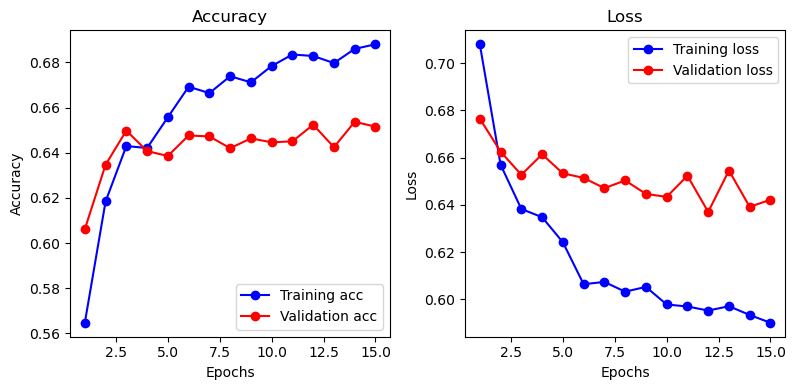

In [8]:
import matplotlib.pyplot as plt

# history から値を取得
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
auc = history.history.get('auc', [])
val_auc = history.history.get('val_auc', [])
recall = history.history.get('recall', [])
val_recall = history.history.get('val_recall', [])

epochs = range(1, len(acc) + 1)

# 精度の可視化
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 損失の可視化
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# AUCの可視化（あれば）
if auc:
    plt.subplot(1, 3, 3)
    plt.plot(epochs, auc, 'bo-', label='Training AUC')
    plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

plt.tight_layout()
plt.show()

# Recallも表示（オプション）
if recall:
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, recall, 'bo-', label='Training Recall')
    plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()
    plt.show()